## Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Change Directory

In [0]:
import os
os.chdir("/content/drive/My Drive/Project/Signs/")
#!unzip signs.zip

## Load Libraries

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob
import cv2
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings("ignore")

### Visualize a sample of images

In [0]:
import random
def get_image_samples(dir):
  animals = os.listdir('signs/' + dir)
  sample_images = []
  for a in animals:
    dirname = 'signs/'+dir+'/' + a
    files = random.sample(glob.glob(dirname + '/*.jp*' ), 7)
    #files = [dirname + '/' + im for im in files]
    sample_images.append("text")
    sample_images.extend(files)

  return animals, sample_images

animals_train, sample_images_train = get_image_samples('train')
animals_valid, sample_images_valid = get_image_samples('valid')
animals_test, sample_images_test = get_image_samples('test')


In [0]:
def show_images(image_list, animal_list):
  plt.clf()
  plt.figure(figsize = (10,15))
  for idx, si in enumerate(image_list):
    if idx % 8 == 0:
      plt.subplot(12, 8, idx+1)
      plt.text(.5, .5, animal_list[idx//8], horizontalalignment='center', verticalalignment='center', fontsize=15)
      plt.axis('off')
      continue

    image = cv2.imread(si)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image = cv2.resize(image, (64, 64))

    plt.subplot(12, 8, idx+1)
    plt.imshow(image)
    plt.axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)  
  plt.show()

<Figure size 432x288 with 0 Axes>

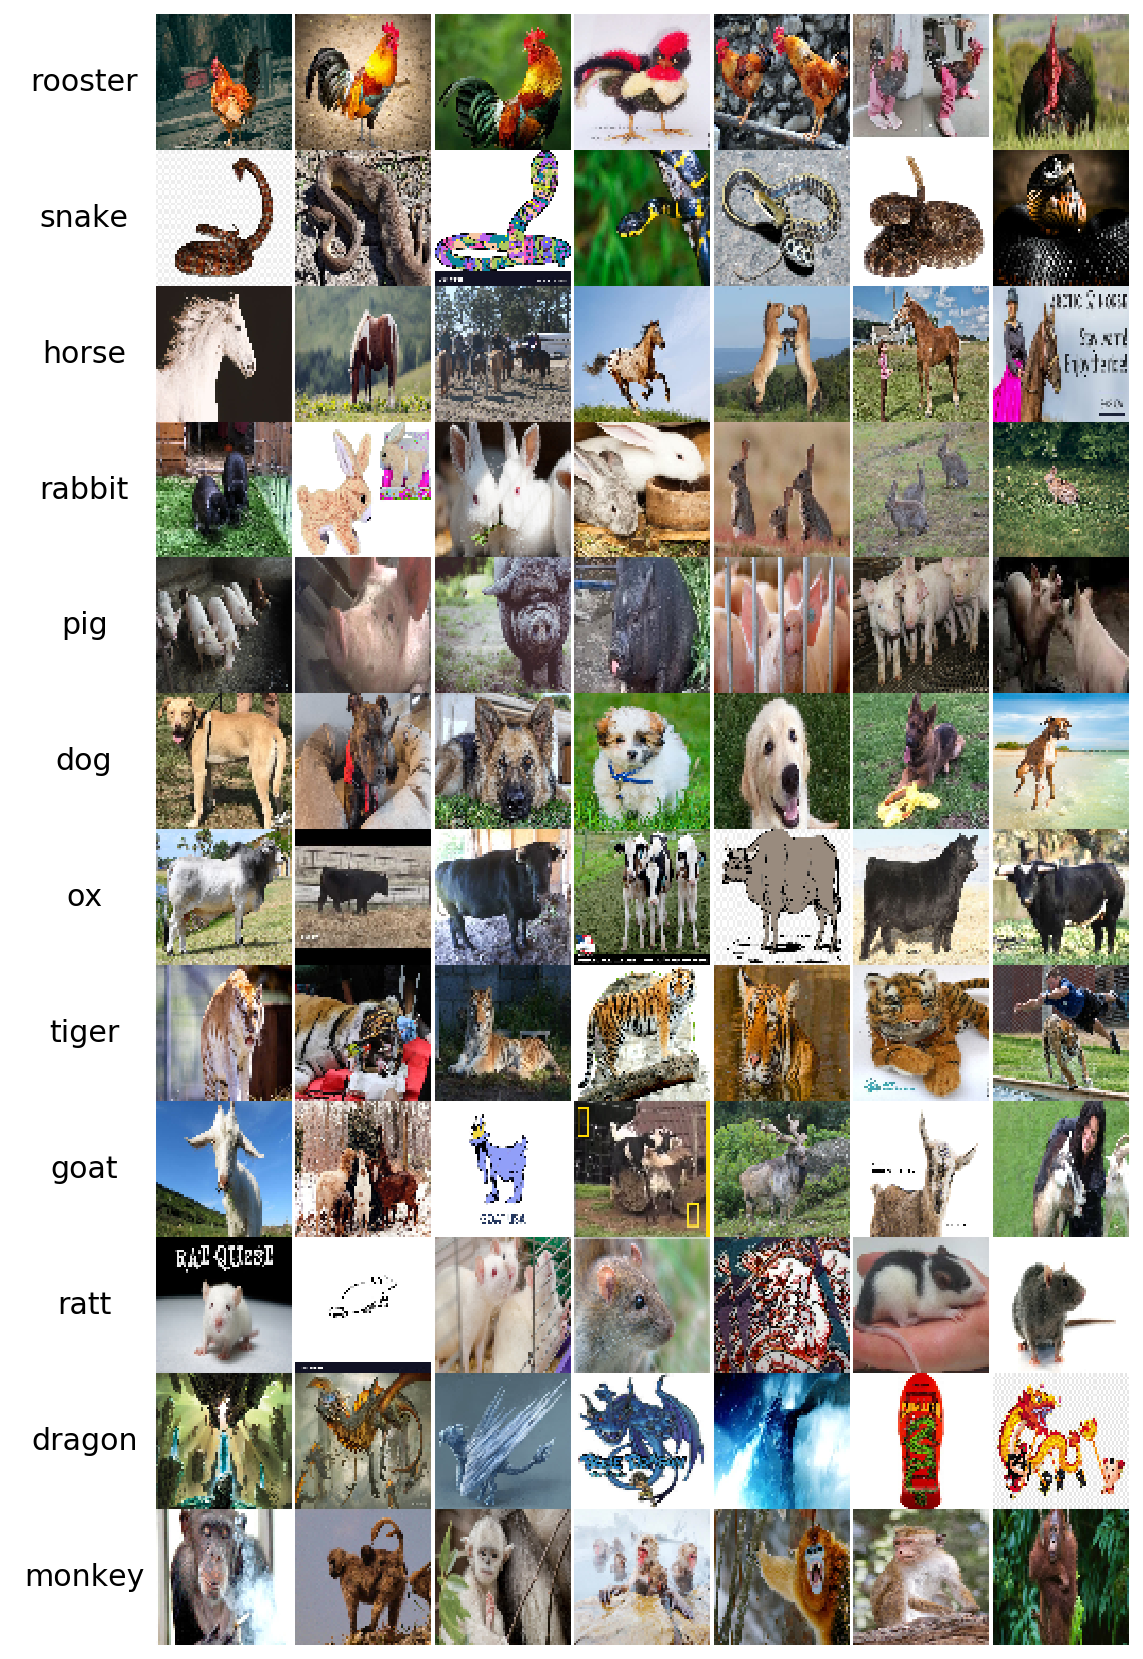

In [0]:
show_images(sample_images_train, animals_train)

<Figure size 432x288 with 0 Axes>

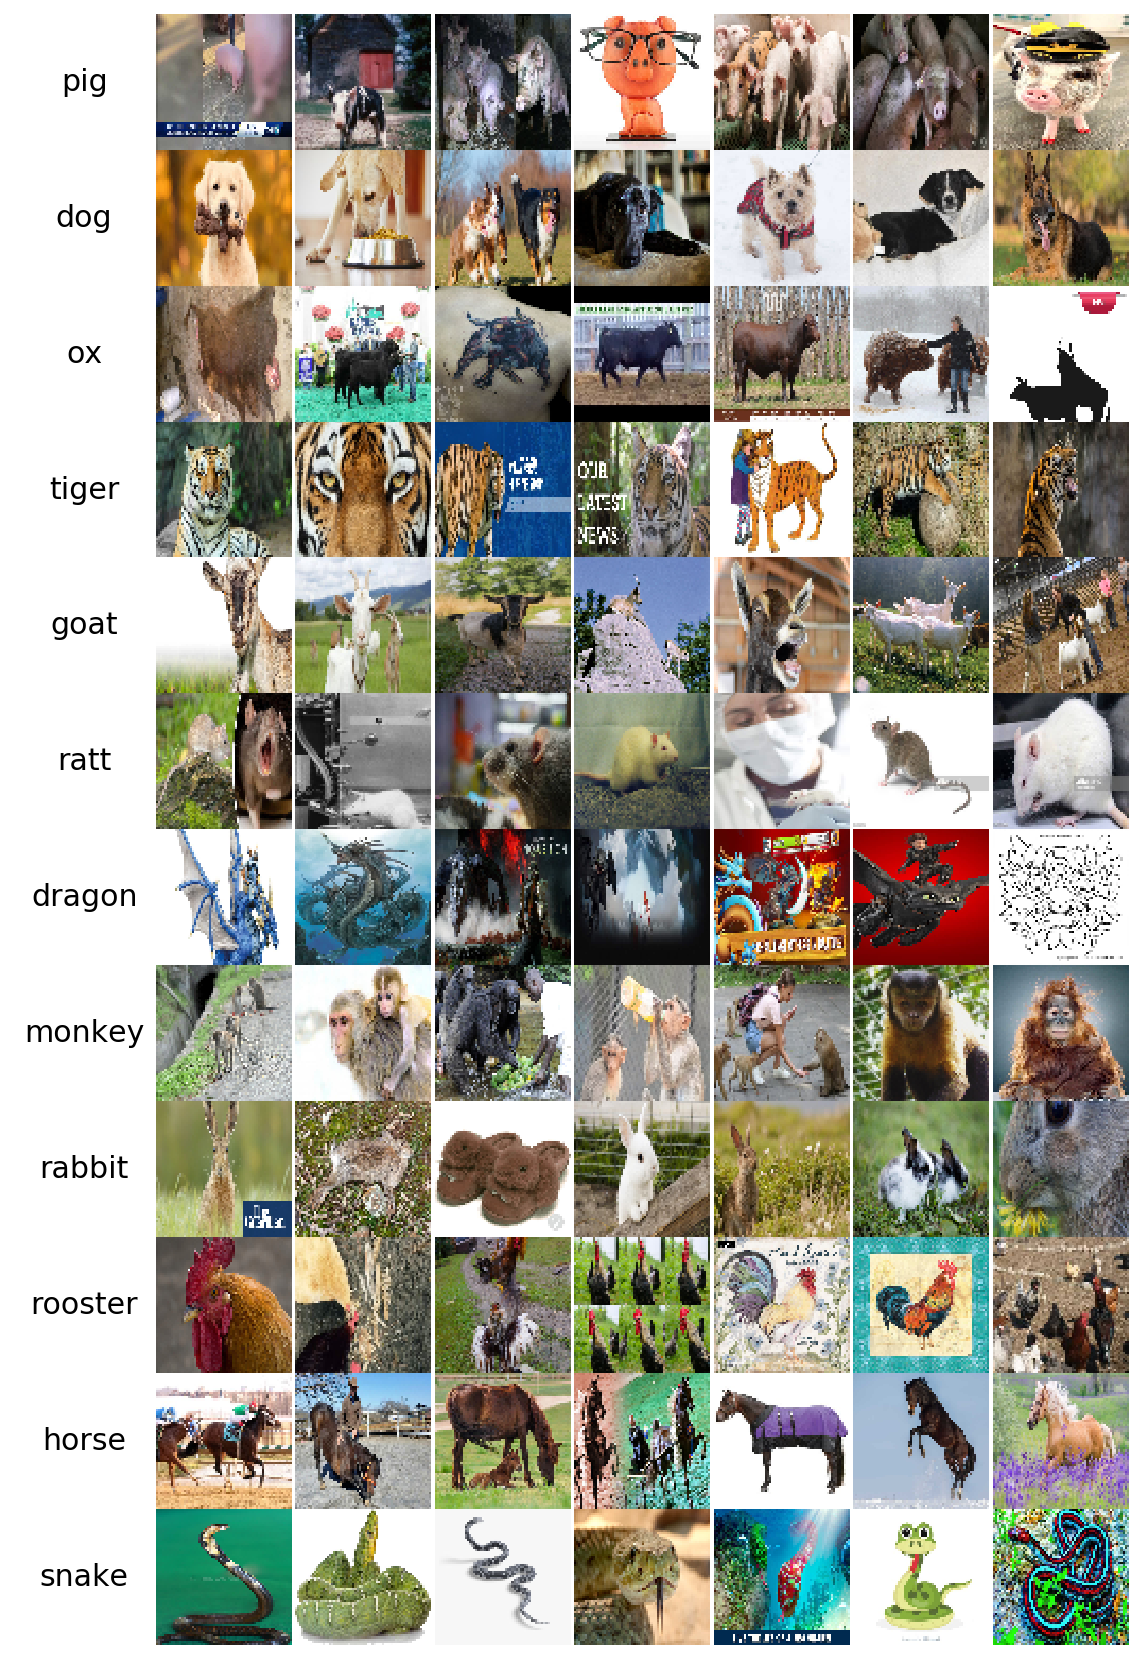

In [0]:
show_images(sample_images_valid, animals_valid)

<Figure size 432x288 with 0 Axes>

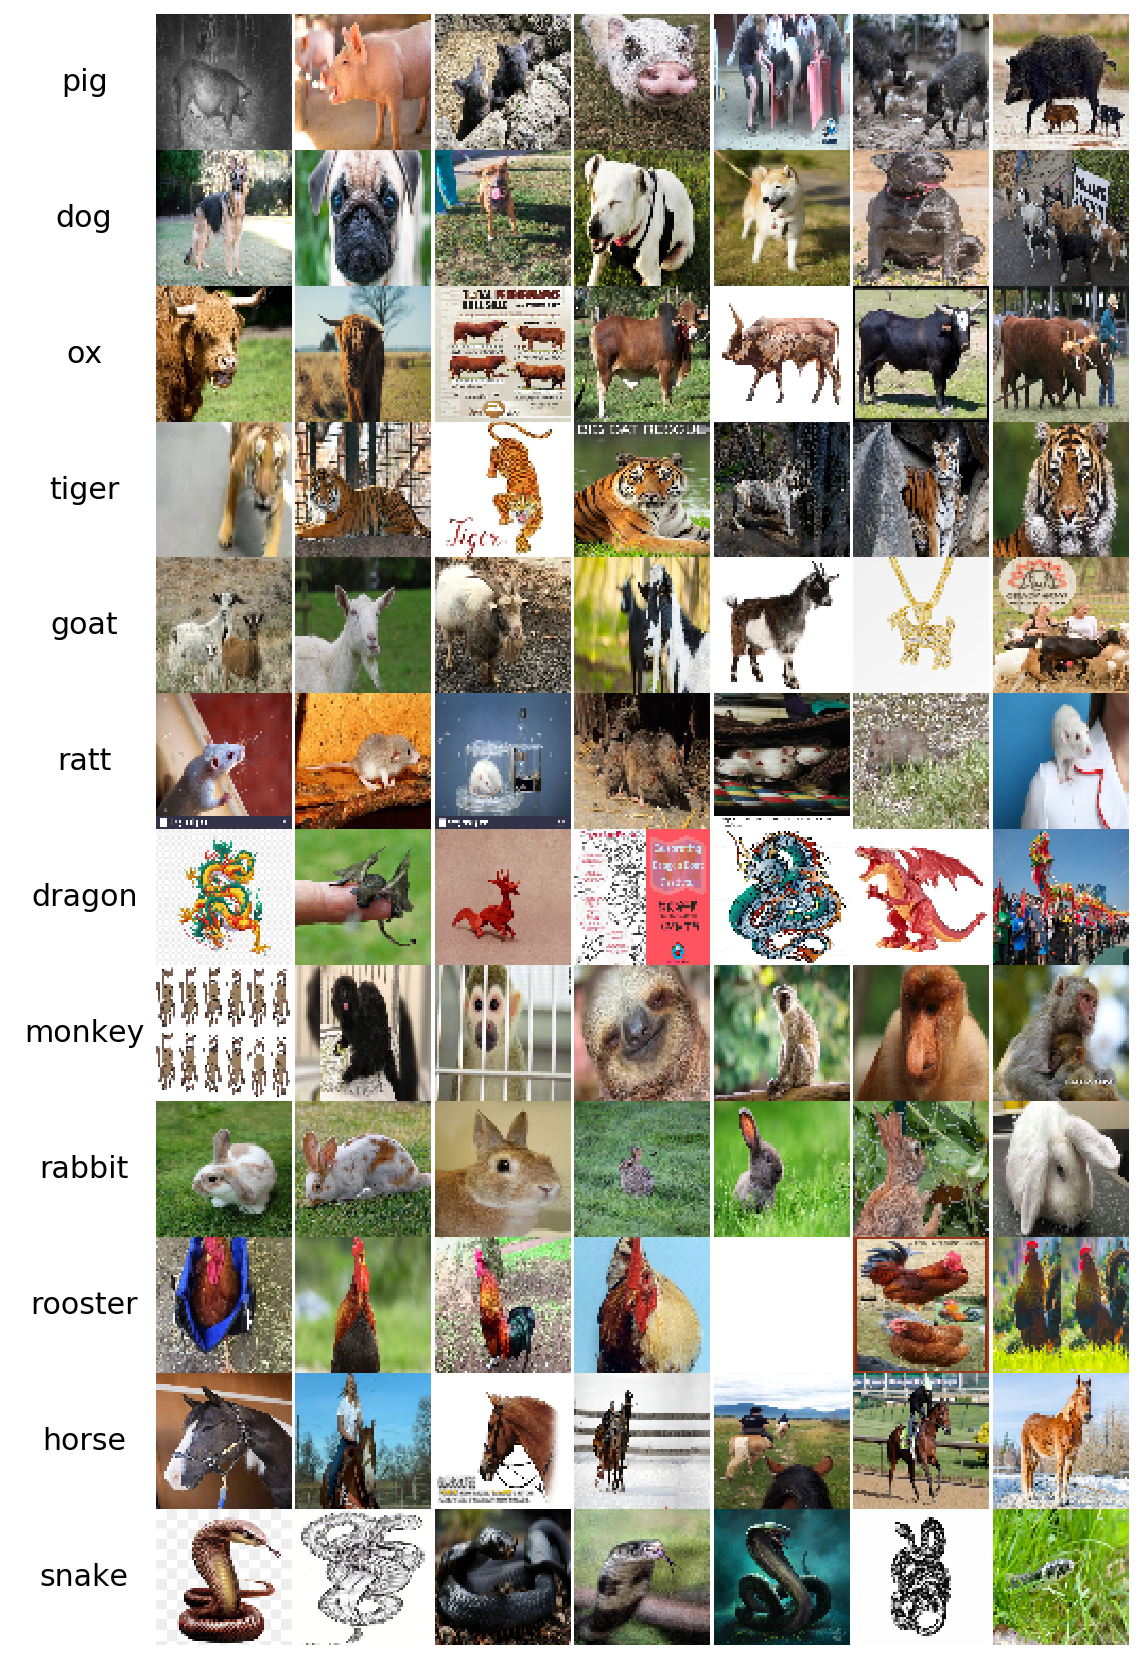

In [0]:
show_images(sample_images_test, animals_test)

## Create Data Loader and Transformations

In [0]:
data_dir = 'signs'

batch_size = 32
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize([224,224]),
                                       transforms.RandomHorizontalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

val_transforms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)




### Create Models

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 12),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 203MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train Model

In [0]:
running_loss = 0.0
running_val_loss = 0.0
running_losses = []
running_val_losses = []
train_acc = 0.0
val_acc = 0.0

train_datas = 0
val_datas = 0

running_train_acc = []
running_val_acc = []

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        i_, l_ = data
        inputs = i_.to(device)
        labels = l_.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, prediction = torch.max(outputs.data, 1)
        train_acc += torch.sum(prediction == labels.data).item()
        train_datas += prediction.shape[0]

        if i % 100 == 99:    # print every 100 mini-batches
            model.eval()

            for i_v, data_v in enumerate(validloader):
              i_, l_ = data_v
              inputs = i_.to(device)
              labels = l_.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              running_val_loss += loss.item()

              _, prediction = torch.max(outputs.data, 1)
              val_acc += torch.sum(prediction == labels.data).item()
              val_datas += prediction.shape[0]

            print('[%d, %5d]\ttrain loss: %.3f\tval loss: %.3f\t---train acc: %.3f\tval acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, running_val_loss / len(validloader), train_acc / train_datas, val_acc / val_datas ))
            running_losses.append(running_loss / 100)
            running_val_losses.append(running_val_loss / len(validloader))
            running_train_acc.append(train_acc / train_datas)
            running_val_acc.append(val_acc / val_datas)
            running_loss = 0.0
            running_val_loss = 0.0
            train_acc = 0.0
            val_acc = 0.0            
            train_datas = 0
            val_datas = 0
            model.train()

print('Finished Training')

[1,   100]	train loss: 0.774	val loss: 0.438	---train acc: 0.759	val acc: 0.875
[1,   200]	train loss: 0.501	val loss: 0.304	---train acc: 0.837	val acc: 0.895
[2,   100]	train loss: 0.409	val loss: 0.295	---train acc: 0.860	val acc: 0.905
[2,   200]	train loss: 0.371	val loss: 0.324	---train acc: 0.884	val acc: 0.895
[3,   100]	train loss: 0.318	val loss: 0.318	---train acc: 0.893	val acc: 0.886
[3,   200]	train loss: 0.361	val loss: 0.329	---train acc: 0.879	val acc: 0.897
[4,   100]	train loss: 0.349	val loss: 0.341	---train acc: 0.885	val acc: 0.885
[4,   200]	train loss: 0.348	val loss: 0.277	---train acc: 0.887	val acc: 0.900
[5,   100]	train loss: 0.295	val loss: 0.281	---train acc: 0.908	val acc: 0.909
[5,   200]	train loss: 0.288	val loss: 0.290	---train acc: 0.904	val acc: 0.914
[6,   100]	train loss: 0.297	val loss: 0.345	---train acc: 0.903	val acc: 0.897
[6,   200]	train loss: 0.318	val loss: 0.301	---train acc: 0.896	val acc: 0.905
[7,   100]	train loss: 0.265	val loss: 0

In [0]:
val_acc = 0.0
val_datas = 0.0
running_val_loss = 0.0

model.eval()

for i_v, data_v in enumerate(validloader):
  i_, l_ = data_v
  inputs = i_.to(device)
  labels = l_.to(device)
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  running_val_loss += loss.item()

  _, prediction = torch.max(outputs.data, 1)
  val_acc += torch.sum(prediction == labels.data).item()
  val_datas += prediction.shape[0]

print('Final eval\tval loss: %.3f\t---val acc: %.3f' %
      ( running_val_loss / len(validloader),  val_acc / val_datas ))
running_val_losses.append(running_val_loss / len(validloader))
running_val_acc.append(val_acc / val_datas)

Final eval	val loss: 0.316	---val acc: 0.909


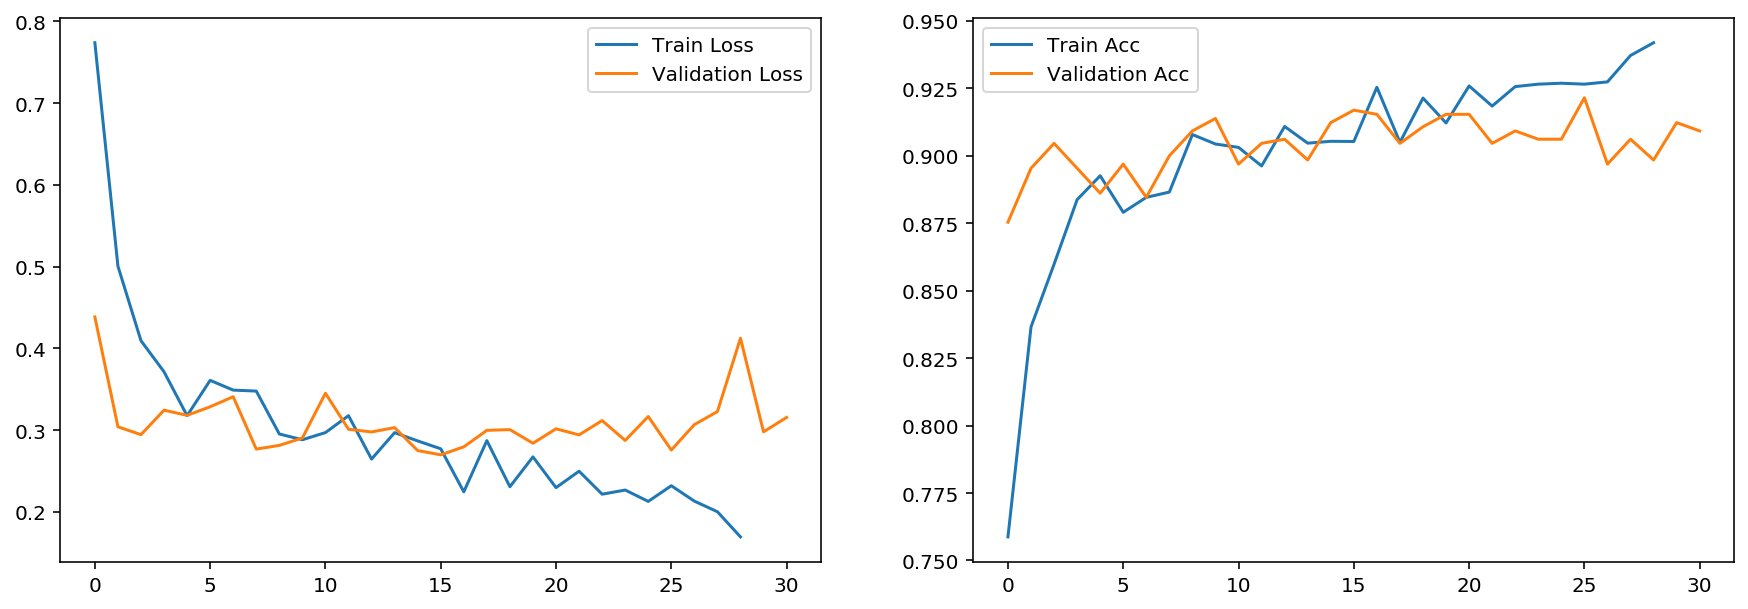

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(len(running_losses)), running_losses , label="Train Loss")
ax[0].plot(range(len(running_val_losses)), running_val_losses, label="Validation Loss")
ax[0].legend()
ax[1].plot(range(len(running_train_acc)), running_train_acc , label="Train Acc")
ax[1].plot(range(len(running_val_acc)), running_val_acc, label="Validation Acc")
ax[1].legend()

### Save model

In [0]:
state = {
    'epoch': 15,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(model.state_dict(), "modeloptim_resnet34_20200114.pt")

# # load for later
# model = models.resnet34(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Sequential(nn.Linear(512, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 12),
#                                  nn.LogSoftmax(dim=1))
# model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])


## Test the model

In [0]:
test_acc = 0.0
test_datas = 0.0
running_test_loss = 0.0

model.eval()

for i_v, data_v in enumerate(testloader):
  i_, l_ = data_v
  inputs = i_.to(device)
  labels = l_.to(device)
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  running_test_loss += loss.item()

  _, prediction = torch.max(outputs.data, 1)
  test_acc += torch.sum(prediction == labels.data).item()
  test_datas += prediction.shape[0]

print('Test model\ttest loss: %.3f\t---test acc: %.3f' %
      ( running_test_loss / len(testloader),  test_acc / test_datas ))


Test model	test loss: 0.311	---test acc: 0.918


## Visualize the test results

In [0]:
testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=4)

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, prediction = torch.max(outputs.data, 1)
correct = prediction == labels

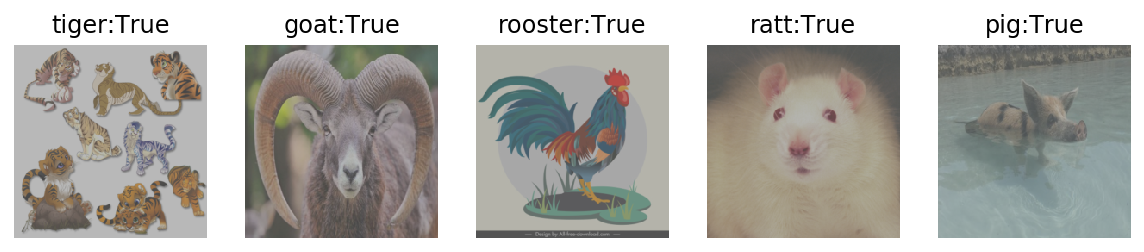

In [0]:
classes = dict(enumerate(testloader.dataset.classes))
correct = correct.to("cpu")
prediction = prediction.to("cpu")
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize = (10,15))
for ii in range(len(images[:5])):
    image = images[ii].to("cpu")
    image = (1/(2*2.25)) * image + 0.5
    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    
    sub = fig.add_subplot(1, 5, ii+1)
    sub.set_title(str(classes[int(prediction[ii])]) + ":" + str(correct.numpy()[ii]))
    plt.axis('off')
    plt.imshow(image)
fig.show()